In [1]:
import torch

from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective import Hypervolume

from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector
from scalarize.test_functions.multi_objective import FourBarTrussDesign

import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams[
    "text.latex.preamble"
] = r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{color}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
input_dim = 4
output_dim = 2

problem = FourBarTrussDesign(negate=True)
bounds = problem.bounds.to(**tkwargs)

# Get a batch of random samples.
torch.manual_seed(0)
num_samples = 128
grid_length = 32
num_points = grid_length * grid_length

b1 = torch.column_stack([bounds[:, 0], bounds[:, 2]])
b2 = torch.column_stack([bounds[:, 1], bounds[:, 3]])

g1 = torch.linspace(b1[0, 0], b1[1, 0], grid_length).to(**tkwargs)
g2 = torch.linspace(b1[0, 1], b1[1, 1], grid_length).to(**tkwargs)
X, Y = torch.meshgrid(g1, g2, indexing="xy")

X1 = []
for i in range(grid_length):
    X1 += [torch.column_stack([X[i, :], Y[i, :]])]
X1 = torch.cat(X1)
X2 = draw_sobol_samples(bounds=b2, n=num_samples, q=1, seed=2).squeeze(-2)

Ys = torch.zeros(num_samples, num_points, output_dim, **tkwargs)
Xs = torch.zeros(num_samples, num_points, input_dim, **tkwargs)
ones = torch.ones(num_points, 1, **tkwargs)

for n in range(num_samples):
    Xn = torch.column_stack(
        [
            X1[:, 0],
            X2[n, 0] * ones,
            X1[:, 1],
            X2[n, 1] * ones,
        ]
    )
    Yn = problem(Xn)

    Xs[n, ...] = Xn
    Ys[n, ...] = Yn

# Get the lengths.
num_weights = 201
nadir = 0 * torch.ones(1, output_dim, **tkwargs)
t = torch.linspace(0, 1, num_weights, **tkwargs).unsqueeze(-1)
unit_vector = UnitVector(num_objectives=2, transform_label="polar")
weights = unit_vector(t)
scalarization_fn = LengthScalarization(weights=weights, ref_points=nadir)

# Get the Pareto fronts.
rescaled_Ys = torch.zeros(num_samples, num_points, output_dim, **tkwargs)
lengths = torch.zeros(num_samples, num_weights, **tkwargs)
fronts = torch.zeros(num_samples, num_weights, output_dim, **tkwargs)
for n in range(num_samples):
    # Rescale objective vectors to lie in the unit hypercube.
    Yn = torch.column_stack(
        [(Ys[n][:, 0] + 1400) / 1400 + 0.925, (Ys[n][:, 1] + 0.005) / 0.04 + 0.95]
    )
    lengths[n, :] = scalarization_fn(Yn).max(dim=0).values
    rescaled_Ys[n, ...] = Yn
    fronts[n, ...] = nadir + weights * lengths[n, :].unsqueeze(-1)

In [3]:
# Mean.
mean_front = nadir + weights * lengths.mean(dim=0).unsqueeze(-1)

# Hypervolume calculations.
hv = Hypervolume(ref_point=nadir.squeeze(0))

hv_values = torch.zeros(num_samples, **tkwargs)
for n in range(num_samples):
    hv_values[n] = hv.compute(rescaled_Ys[n, ...])
mean_hv = hv_values.mean()

# Bisection.
upper = 1
lower = 0.0
tolerance = 0.001
distance = 1.0

while distance > tolerance:
    middle = (upper + lower) / 2
    quantile_front = nadir + weights * lengths.quantile(middle, dim=0).unsqueeze(-1)
    quantile_hv = hv.compute(quantile_front)
    if quantile_hv > mean_hv:
        upper = middle
    else:
        lower = middle
    distance = abs(quantile_hv - mean_hv)

    print(f"middle={middle}, mean_hv={mean_hv}, hv={quantile_hv}")

middle=0.5, mean_hv=0.510554808803717, hv=0.5249187005909087
middle=0.25, mean_hv=0.510554808803717, hv=0.4327769475732667
middle=0.375, mean_hv=0.510554808803717, hv=0.4822518102583083
middle=0.4375, mean_hv=0.510554808803717, hv=0.500369099331082
middle=0.46875, mean_hv=0.510554808803717, hv=0.5155758760097698
middle=0.453125, mean_hv=0.510554808803717, hv=0.5069509903592534
middle=0.4609375, mean_hv=0.510554808803717, hv=0.5105295868522374


In [4]:
# Domination probabilities.
num_bins = 128
g = torch.linspace(-0.05, 1.1, num_bins).to(**tkwargs)
Z1, Z2 = torch.meshgrid(g, g, indexing="xy")

length_ratios = torch.zeros(num_samples, num_bins, num_bins, **tkwargs)

for i in range(num_bins):
    Y_i = torch.column_stack([Z1[i, :], Z2[i, :]])
    s_fn = LengthScalarization(weights=Y_i - nadir, ref_points=nadir)
    for n in range(num_samples):
        Y_n = rescaled_Ys[n, ...]
        length_ratios[n, i, :] = s_fn(Y_n).max(dim=0).values

domination_probabilities = (length_ratios >= 1).double().mean(dim=0)
mean_deviation = (
    ((length_ratios - 1) * (length_ratios.mean(dim=0) - 1) <= 0).double().mean(dim=0)
)
quantile_deviation = (
    ((length_ratios - 1) * (length_ratios.quantile(middle, dim=0) - 1) < 0)
    .double()
    .mean(dim=0)
)

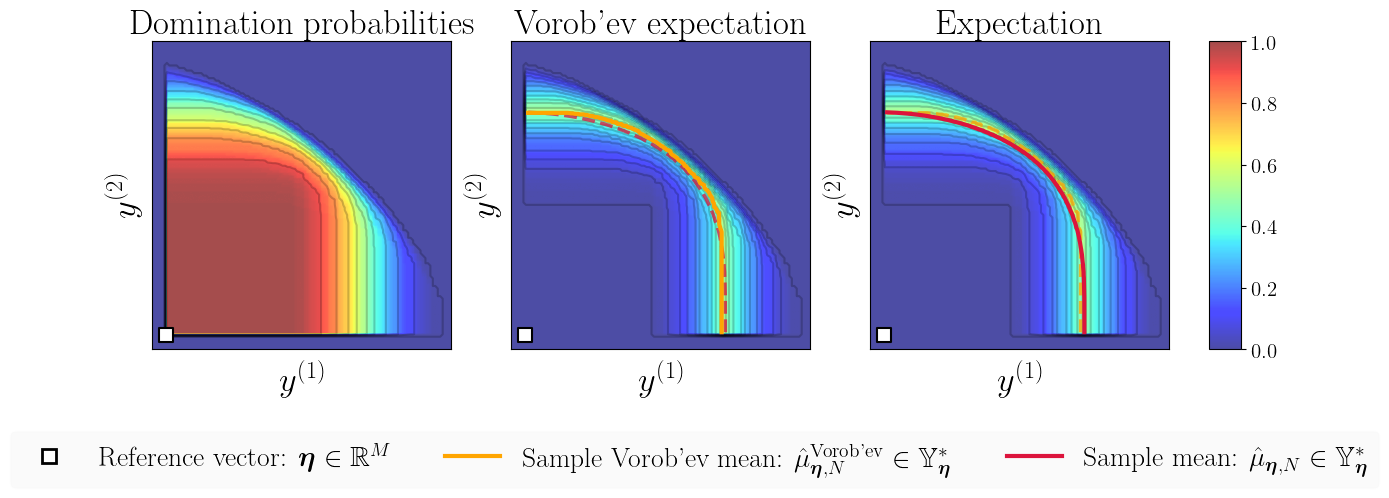

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(13.125, 4))

for i in range(3):
    ax = plt.subplot(1, 3, i + 1)

    ax.scatter(
        nadir[:, 0],
        nadir[:, 1],
        color="w",
        marker="s",
        linestyle="None",
        s=100,
        edgecolors="k",
        linewidth=1.5,
        zorder=5,
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(r"$y^{(1)}$", fontsize=25)
    ax.set_ylabel(r"$y^{(2)}$", fontsize=25)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
####################################################################################
# Domination probabilities.
ax = plt.subplot(1, 3, 1)
ax.contour(Z1, Z2, domination_probabilities, colors="black", alpha=0.2, levels=10)

img = ax.imshow(
    domination_probabilities,
    extent=[-0.05, 1.1, -0.05, 1.1],
    origin="lower",
    cmap="jet",
    alpha=0.7,
    vmin=0.0,
    vmax=1.0,
    aspect="auto",
)
ax.set_title("Domination probabilities", fontsize=25)
####################################################################################
# Vorob'ev mean deviation
ax = plt.subplot(1, 3, 2)
ax.contour(Z1, Z2, quantile_deviation, colors="black", alpha=0.2, levels=10)
img = ax.imshow(
    quantile_deviation,
    extent=[-0.05, 1.1, -0.05, 1.1],
    origin="lower",
    cmap="jet",
    alpha=0.7,
    vmin=0.0,
    vmax=1.0,
    aspect="auto",
)
quantile_front = nadir + weights * lengths.quantile(middle, dim=0).unsqueeze(-1)
ax.plot(
    mean_front[2:-2, 0],
    mean_front[2:-2, 1],
    color="crimson",
    linewidth=2.5,
    linestyle="--",
    alpha=0.75,
)
ax.plot(
    quantile_front[2:-2, 0],
    quantile_front[2:-2, 1],
    color="orange",
    linewidth=3,
    linestyle="-",
)
ax.set_title("Vorob'ev expectation", fontsize=25)
####################################################################################
# Expectation deviation.
ax = plt.subplot(1, 3, 3)
ax.contour(Z1, Z2, mean_deviation, colors="black", alpha=0.2, levels=10)
img = ax.imshow(
    mean_deviation,
    extent=[-0.05, 1.1, -0.05, 1.1],
    origin="lower",
    cmap="jet",
    alpha=0.7,
    vmin=0.0,
    vmax=1.0,
    aspect="auto",
)
ax.plot(
    quantile_front[2:-2, 0],
    quantile_front[2:-2, 1],
    color="orange",
    linewidth=2.5,
    linestyle="--",
    alpha=0.75,
)
ax.plot(
    mean_front[2:-2, 0],
    mean_front[2:-2, 1],
    color="crimson",
    linewidth=3,
    linestyle="-",
)
ax.set_title("Expectation", fontsize=25)

# Colourbar.
cmap = plt.get_cmap("jet")
norm = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
ax_bar = fig.add_axes([0.93, 0.11, 0.025, 0.77])
cbar = matplotlib.colorbar.ColorbarBase(
    ax_bar,
    cmap=cmap,
    spacing="proportional",
    orientation="vertical",
    norm=norm,
)
cbar.ax.tick_params(labelsize=15)
cbar.solids.set(alpha=0.7)
####################################################################################
# Legend.
white_square = mlines.Line2D(
    [],
    [],
    color="w",
    marker="s",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Reference vector: $\boldsymbol{\eta} \in \mathbb{R}^M$",
)

orange_line = mlines.Line2D(
    [],
    [],
    color="orange",
    linestyle="-",
    linewidth=3,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Sample Vorob'ev mean: $\hat{\mu}^{\text{Vorob'ev}}_{\boldsymbol{\eta}, N} \in \mathbb{Y}^*_{\boldsymbol{\eta}}$",
)

red_line = mlines.Line2D(
    [],
    [],
    color="crimson",
    linestyle="-",
    linewidth=3,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Sample mean: $\hat{\mu}_{\boldsymbol{\eta}, N} \in \mathbb{Y}^*_{\boldsymbol{\eta}}$",
)

axes[0].legend(
    handles=[white_square, orange_line, red_line],
    ncol=3,
    fontsize=20,
    loc=(-0.475, -0.45),
    facecolor="k",
    framealpha=0.02,
)

plt.show()